#### **Axion conversion code**

The following notebook has some potentially useful functions for the axion conversion numerical integration.

In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u 

from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import fsolve
from scipy.optimize import root_scalar

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### **INitialize Battaglia Profile**

Note that the variables used here are slightly different than the function I sent last time. This code computes R200c from M200c and the cosmological parameters (to compute the critical density)

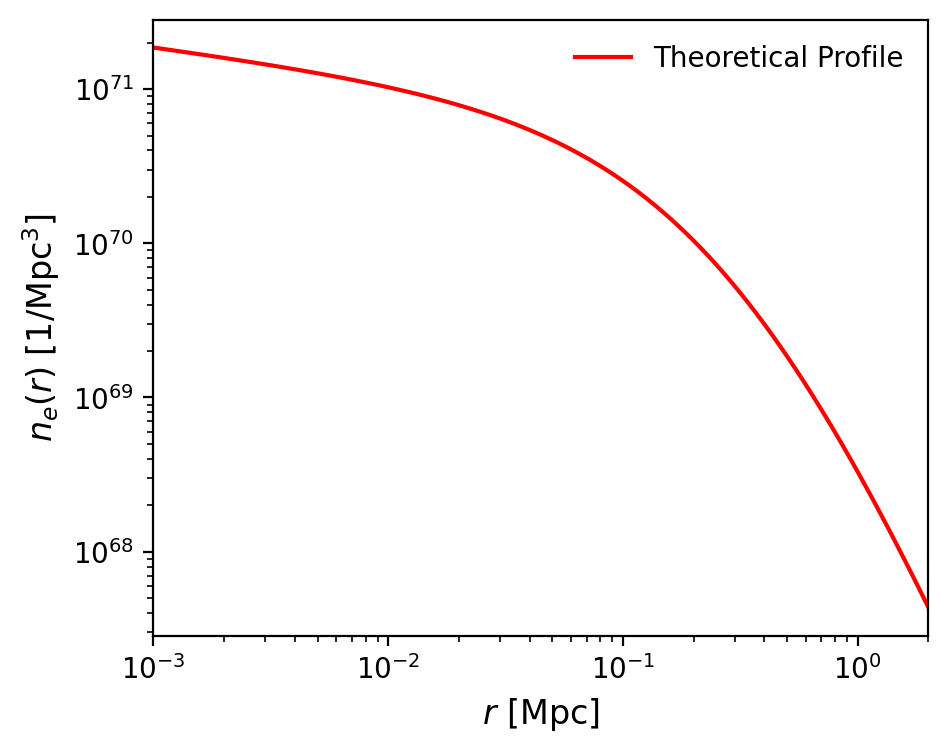

In [6]:
def get_ne_battaglia(r, M200c, z, H0, Omega_b, Omega_m, param_dict=None):
    """
    Computes Battaglia profile as a function of radius. Parameterized in terms
    of cosmological parameters: H0, Omega_b, and Omega_m
    
    Parameters:
       r: Radius in Mpc
       M200c: M200c in Msun
       z: Redshift
       H0: in km/s/Mpc
       Omega_b: baryon density
       Omega_m: matter density
       param_dict: Optional parameters for profile
       
    Returns:
       Electron number density profile in (1/Mpc**3)
    """

    # Compute criical density at redshift z (ignores radiation)
    rho_critz = (3*(H0*u.km/u.s/u.Mpc)**2/(8*np.pi*const.G)).to(u.Msun/u.Mpc**3).value*(Omega_m*(1+z)**3+(1-Omega_m)) # Msun/Mpc^3

    # Compute R200c from M200c and critical density
    R200c = (3*M200c/(4*np.pi*200*rho_critz))**(1/3) # in Mpc
    
    # Unit conversion
    m_p = 8.411856872862986e-58 # Proton mass in units of Msun
    
    if param_dict is None:
        # Get Battaglia profile parameters at appropriate redshift
        rho0  = 4000. * (M200c/1e14)**0.29    * (1.+z)**(-0.66)
        alpha = 0.88  * (M200c/1e14)**(-0.03) * (1.+z)**0.19
        beta  = 3.83  * (M200c/1e14)**0.04    * (1.+z)**(-0.025)
        gamma = -0.2

    else:
        rho0  = param_dict['rho0']
        alpha = param_dict['alpha']
        beta  = param_dict['beta']
        gamma = param_dict['gamma']
    
    x = 2*r/R200c    
    fb = Omega_b/Omega_m
    
    rho_gas = fb*rho_critz*rho0 * (x**gamma) * ((1.+x**alpha)**(-(beta+gamma)/alpha))
    ne_prof = (1+0.76)/(2*m_p)*rho_gas 
    
    return ne_prof



########################################################################
# Example calculation
########################################################################
omch2 = 0.1201
ombh2 = 0.0224
h = 0.6732
A_s = 2.100583e-09
n_s = 0.9661
tau = 0.0543
z = 0
cosmo_params = {'omch2': omch2, 'ombh2': ombh2, 'H0': 100*h, 
                'As': A_s, 'ns': n_s, 'tau': tau}

# Derived parameters that are useful for unit conversions
Omega_m = (cosmo_params['omch2']+cosmo_params['ombh2'])/h**2
Omega_b = cosmo_params['ombh2']/h**2
H0 = 100*h

# Halo settings
M200c = 10**13.5 # Msun

# Compute profile
r_thr  = np.logspace(-3, np.log10(2), 100) # radius in Mpc
ne_thr = get_ne_battaglia(r_thr, M200c, z, H0, Omega_b, Omega_m) #1/Mpc^3

# Interpolate profile (we use a logarithmic interpolator for better accuracy)
log_ne_log_r_interp = interp1d(np.log10(r_thr), np.log10(ne_thr))
ne_interp = lambda r: 10**log_ne_log_r_interp(np.log10(r))

########################################################################
# Make plot
########################################################################
plt.figure(figsize=(5,4))
plt.plot(r_thr, ne_thr, color='r', label='Theoretical Profile')
plt.legend(frameon=False)
plt.xlim(1e-3, 2)
plt.xlabel(r"$r~[{\rm Mpc}]$", fontsize=12)
plt.ylabel(r"$n_e(r)~[1/{\rm Mpc}^3]$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

#### **Create halo realization and find resonances**
Now that we have a spherically averaged profile, we want to create a realization of the halo. To do this, I will set the halo center at $z=2$ Mpc and consider the range $0\leq z\leq 4$ Mpc. We can then add noise on top of the spherically averaged profile. Once we have a noisy profile, we will compute the resonant locations 

In [45]:
from scipy.ndimage import gaussian_filter1d


#################################################################
# Generate halo realization with noise
#################################################################
z_cen = 2 # Center of halo
z_min = 0
z_max = 4
Nz    = 1000
z_thr = np.linspace(z_min, z_max, Nz)
r_thr = np.abs(z_thr-z_cen) # Radial distance from center of halo

ne_battaglia_thr = ne_interp(r_thr)

# Add in some smooth Gaussian noise
noise = rng.normal(loc=0.0, scale=1.0, size=Nz)
smooth_noise = gaussian_filter1d(noise, sigma=Nz/5e3)  

amplitude = 0.1
ne_battaglia_thr_noisy = ne_battaglia_thr * (1 + amplitude * smooth_noise)

#################################################################
# Find resonance points
#################################################################
def find_all_roots(func, x_min, x_max, N_x=1000):
    """
    Finds all roots of a function (func) in an interval
    between xmin and xmax
    """
    x = np.linspace(x_min, x_max, N_x)
    f_vals = func(x)
    
    roots = []
    for i in range(len(x) - 1):
        if f_vals[i] * f_vals[i + 1] < 0:  # Sign change
            bracket = [x[i], x[i+1]]
            result = root_scalar(func, bracket=bracket, method='brentq')
            if result.converged:
                roots.append(result.root)
    
    return roots


# Set an arbitrary electron density for resonant conversion. This is set by the axion mass, but
# I'm just going to fix it to a number here as an example
ne_res = 1*1e69

# Interpolate the noisy profile
log_ne_noisy_log_r_interp = interp1d(z_thr, np.log10(ne_battaglia_thr_noisy))
ne_noisy_interp = lambda r: 10**log_ne_noisy_log_r_interp(r)

Delta_diff = lambda r: ne_noisy_interp(r)-ne_res # Difference between ne of noisy profile and the resonacne value

res_locs = find_all_roots(Delta_diff, 1.0001*z_min, 0.9999*z_max) # Note we use 1.0001 and 0.9999 just to avoid using interpolator outside of bounds. We could use a different interpolator or change this region

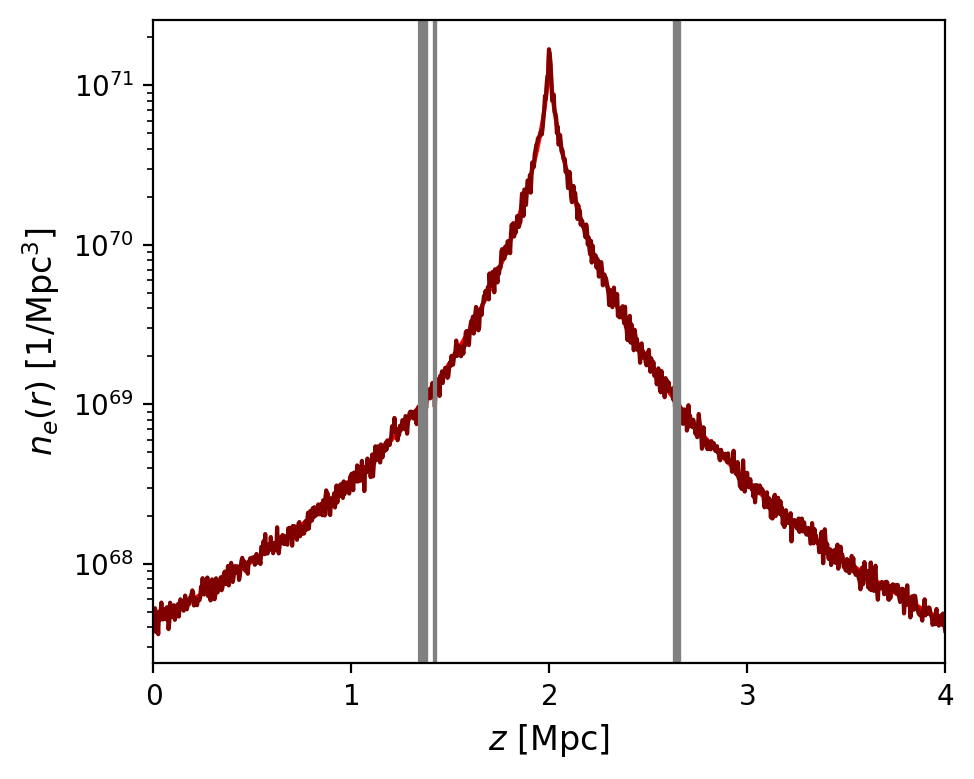

In [46]:
plt.figure(figsize=(5,4))
plt.plot(z_thr, ne_battaglia_thr, color='r')
plt.plot(z_thr, ne_battaglia_thr_noisy, color='Maroon')
#plt.axhline(ne_res, color='k', linestyle='--')

# Plot resonance
for res in res_locs:
    plt.axvline(res, color='gray', linestyle='-')
plt.xlabel(r"$z~[{\rm Mpc}]$", fontsize=12)
plt.ylabel(r"$n_e(r)~[1/{\rm Mpc}^3]$", fontsize=12)

plt.xlim(0, 4)
plt.xticks([0,1,2,3,4])
plt.yscale("log")
plt.tight_layout()

#### **Check that resonances are correclty identified**
It is hard to see the resonances because the plot is noisy so we should make sure that they corresopnd to actual zeros in the difference between the noisy profile and the resonant electron number desnity. We can see that it is correctly identifying all of the resonances by looking at the zoomed region.

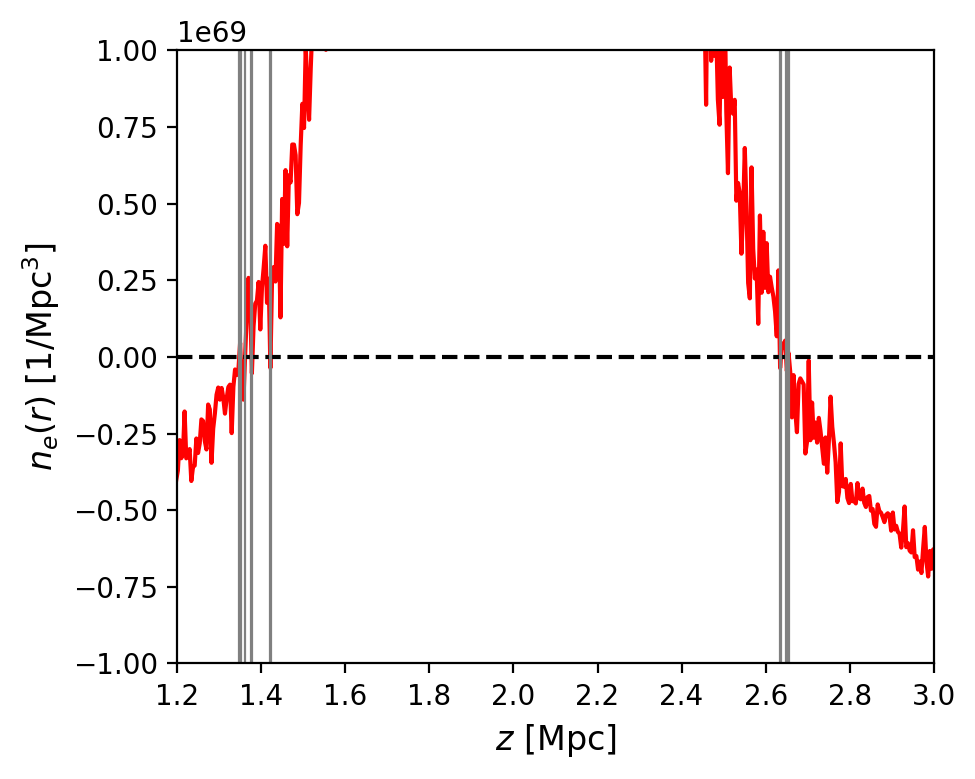

In [47]:
plt.figure(figsize=(5,4))
plt.plot(z_thr, ne_battaglia_thr_noisy-ne_res, color='r')
plt.axhline(0, color='k', linestyle='--')

#Plot resonance
for res in res_locs:
    plt.axvline(res, color='gray', linestyle='-', linewidth=0.8)
plt.xlabel(r"$z~[{\rm Mpc}]$", fontsize=12)
plt.ylabel(r"$n_e(r)~[1/{\rm Mpc}^3]$", fontsize=12)
plt.ylim(-1e69, 1e69)
plt.xlim(1.2, 3)

plt.tight_layout()

#### **Adjusting t_eval**

The ODE solver has a t_eval variable which determines the times at which it saves output. Using more evaluations slows things down, so we should try to use a non-uniform sampling of t_eval that is denser near the resonances. Here is some example code that uses two different linear spacings depending on how close you are to a resonance. If the nearest resonance is within the radius variable, then you use a fine spacing, otherwise uses a coarse spacing. The widht and radius are parameters set by the user. You should be able to use something similar to this to set t_eval

In [48]:
import numpy as np

def adaptive_zvals(zmin, zmax, zres, dz_coarse=1e-1, dz_fine=1e-4, radius=0.1):
    """
    Generate z values with fine sampling near resonances.

    Parameters:
        zmin, zmax : float, minimum and maximum range 
        dz_coarse, dz_fine : float
        resonances : list or array of redshift resonance locations
        radius : float, defines 'near resonance' region around each resonance
    NOTE: example values here for dz_coarse, dz_fine, and radius are potentially representative
    values to use in units of Mpc
    Returns:
        zvals : sorted array of unique z values
    """
    zvals = []

    # Coarse grid
    z_coarse = np.arange(zmin, zmax + dz_coarse, dz_coarse)

    for z in z_coarse:
        # If within 'radius' of any resonance, use fine grid around it
        if any(abs(z - zres) < radius for zres in zres):
            zvals.extend(np.arange(z - dz_coarse, z + dz_coarse, dz_fine))
        else:
            zvals.append(z)

    # Remove duplicates and sort
    zvals = np.unique(np.clip(zvals, zmin, zmax))

    return zvals

z_eval = adaptive_zvals(z_min, z_max, res_locs, dz_coarse=1e-1, dz_fine=1e-3, radius=0.1)

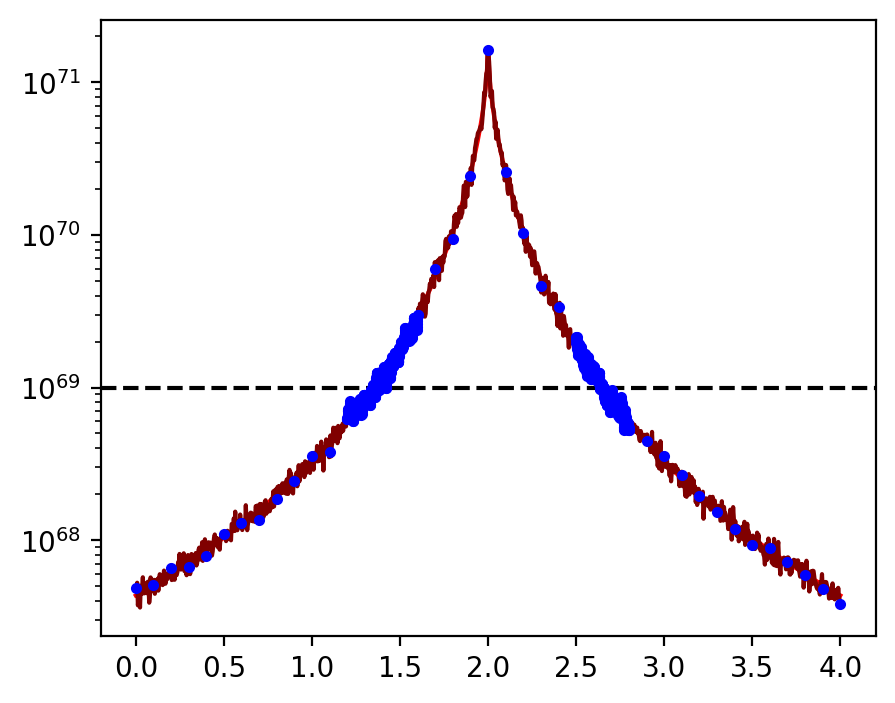

In [50]:
plt.figure(figsize=(5,4))
plt.plot(z_thr, ne_battaglia_thr, color='r')
plt.axhline(ne_res, color='k', linestyle='--')
plt.plot(z_thr, ne_battaglia_thr_noisy, color='Maroon')
plt.plot(z_eval, ne_noisy_interp(z_eval), marker='.', linestyle='None', color='b')
plt.yscale("log")